# This notebook is for the H-partitioning project, to be done complementary with the MAGEC code (Chen Sun+), which can set the initial conditions.  
# Currently, this notebook only follows the magma ocean phase. All inputs, figures, etc. are based on Model 2 of our coupled M-Earth model (see Moore, Cowan, Boukare 2023).
## ** We assume a bulk silicate Earth composition (BSE) after McDonough & Sun (1995).

# -----
## A logical step would be to implement the ideas contained within this notebook (i.e., core-MO water partitioning and transition zone water partitioning during magma ocean solidification) into the "cleaned" version of the box model outlined in Moore, David, Zhang, Cowan 2024.
### HERE, all functions are contained within the notebook. In the Moore+2024 box model, however, the input files and functions are separate from the simulation files, making for a cleaner experience. HOWEVER, I did not implement the core partitioning changes here into the magma ocean model from Moore+2024 yet simply due to debugging the model within this current notebook.
# -----

# ASSUMPTIONS:
## MINIMUM VALUE OF WATER IN MANTLE SAME AS SURFACE DESICCATION LIMIT, TO AVOID ETA --> INFINITY!!!!

## - Luger & Barnes assume 10 Myr formation time; Earth's magma ocean phase ~1.5 Myr; since this is extended around M dwarfs (Lebrun+13); then, WE OFFSET Baraffe+2015 STELLAR TRACKS BY 5 Myr!
## - CONSTANT thermospheric temperature = 400 K (diffusion-limited escape; discussed in Moore et al. 2024)
## - Pure H2O atmosphere currently, BUT this could be updated by further implementing details of the MAGEC code from Chen Sun. 

######################################################################################################################

# Initialize notebook; import required functions/packages, and read in input parameters/variables from .txt files.

In [1]:
%pylab inline
import math
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import *
from scipy.integrate import ode
#from mpl_toolkits.axes_grid.inset_locator import inset_axes
import time
import os.path

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Read in global variables for model from associated .txt files (details below, and in Moore & Cowan 2020, Moore et al. 2023)

In [2]:
# Need to divide constants into three categories

# 1) Unchanging constants
# [M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry]

params1 = np.loadtxt('const_params.txt')
M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1

# 2) Varied parameters
# [x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
#  T_serp, K_cnst, gamma, r_fug, d_b]

params2 = np.loadtxt('vary_params.txt')
x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
     T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
# Test different betas; see if the code breaks
#beta = 0.12
#params2[11] = beta

# 3) Changing parameters
# [omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt]

params3 = np.loadtxt('change_params.txt')
omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
dt_nom = 2.0e4*year
params3[8] = dt_nom

# NEW constants, for 1-D atmosphere calculations
sigma_sb = 5.67e-8 #[W/m^2/K^4]; Stefan-Boltzmann constant
m_H = 1.66e-27 #[kg]; mass of H atom
k_B = 1.38e-23 #[m^2 kg s^-2 K^-1]; Boltzmann constant
m_H2O = 18.02*m_H #molecular mass of water
m_air = 28.7*m_H #molecular mass of air on Earth
rho_water = 997. #[kg/m^3]; density of water
cp_water_vapour = 1.996e3 #[J/(kg K)]; specific heat capacity of water vapour (steam)

## INPUT PARAMETERS: Planet orbital distance and albedo
### The orbital distance can be set here for a single run, but it is set further down for a parameter space search of orbital distances located at the Inner HZ, Mid HZ, and Outer HZ for the given host star input file.

In [3]:
# Parameters of orbiting planet (can be changed later).
#a_orb = 0.06*1.496e11 #[m], roughly middle of HZ around Proxima Cen
alb = 0.3 #albedo; value roughly similar to Earth
#alb = 0.75 #albedo; upper limit to roughly test "steam atmosphere"

# Model Functions/Calculated Constants

In [4]:
## WATER FUGACITY
# Need to calculate non-dimensional water fugacity at each step.
# Formula original from Li et al. (2008), based on experimental data.
def lnf_w(x, params1, params2, params3): #NOTE: Takes non-dimensionalized mantle water mass fraction and converts it.
    c0 = -7.9859
    c1 = 4.3559
    c2 = -0.5742
    c3 = 0.0337
    B = 2.0e6
    mu_oliv = 153.31
    mu_wat = 18.01528
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    ln_term = np.log((B*x*(mu_oliv/mu_wat))/(1.-(x*(mu_oliv/mu_wat))))
    
    return c0 + c1*ln_term + c2*ln_term**2. + c3*ln_term**3.

def f_w(x, params1, params2, params3):
    
    return np.exp(lnf_w(x, params1, params2, params3))

In [5]:
## MANTLE VISCOSITY

# Need a function to calculate the viscosity.
def eta(temp, x, params1, params2, params3): #x and T are non-dimensionalized later in code -- need to add dimensions back for these calculations
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    eta_scale = (np.exp(lnf_w(5.8e-4,params1,params2,params3)))**(-r_fug)
    eta_0 = 1.0e21/eta_scale
        
    # Need a minimum fugacity, to avoid f_w --> 0 and eta --> infinity.
    # Let's take the 'desiccation limit' for the surface as the minimum value to be 'trapped' in the mantle.
    if x <= 1.29e16/(f_M*M_E):
        return eta_0*(f_w(1.29e16/(f_M*M_E), params1, params2, params3)**(-r_fug)) * np.exp((E_a/R_g)*((1./temp) - (1./T_ref)))
    else:
        return eta_0*(f_w(x, params1, params2, params3)**(-r_fug)) * np.exp((E_a/R_g)*((1./temp) - (1./T_ref)))
    
    #if f_w(x, params1, params2, params3) > f_w_min:
    #    return eta_0 * (f_w(x, params1, params2, params3)**(-r_fug)) * np.exp((E_a/R_g)*((1./temp) - (1./T_ref)))
    #elif f_w(x, params1, params2, params3) <= f_w_min:
    #    return eta_0 * (f_w_min**(-r_fug)) * np.exp((E_a/R_g)*((1./temp) - (1./T_ref)))

In [6]:
def Rp(M):
    M_E = 5.972e24
    R_E = 6.371e6
    return R_E*(M/M_E)**0.27

def Rc(M):
    M_E = 5.972e24
    R_E = 6.371e6
    return 0.547*R_E*(M/M_E)**0.25

def h(M):
    return Rp(M) - Rc(M)

def g(M):
    G = 6.67e-11
    return G*M/(Rp(M)**2.)

def A(M):
    return 4.*np.pi*(Rp(M)**2.)

def V(M):
    return (4.*np.pi/3.)*((Rp(M)**3.) - (Rc(M)**3.))

def F_0(M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    eta_scale = (np.exp(lnf_w(1.,params1,params2,params3)))**(-r_fug)
    eta_0 = 1.e21/eta_scale

    f_w = np.exp(lnf_w(5.8e-4,params1,params2,params3))
    return (k*(T_ref**(1.+beta))*A(M)/(h(M)*V(M)))*(alpha*rho_m*g(M)*(h(M)**3.)*f_w/(Ra_c*kappa*eta_0))**beta

def L_MOR(M):
    return 1.5*2.*np.pi*Rp(M)

def S(t, temp, x, T_surf, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return 10.76*(kappa**(1.-2.*beta))*(h(M)**(6.*beta-1.))*((alpha*rho_m*g(M)*\
            (temp-T_surf)/(eta(temp,x,params1,params2,params3)*Ra_c))**(2.*beta))

def tau(M, params1, params2, params3): #useful for converting between different non-dimensional timescales
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return (L_MOR(M)*(0.1/year)*x_h*rho_c*chi*d_hE)/(M*omega_0*f_btwid) #spreading rate independent of temp in this model

def Ra(t, temp, x, T_surf, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return (alpha*rho_m*g(M)*(temp - T_surf)*(h(M)**3))/(eta(temp, x, params1, params2, params3)*kappa)

# Nusselt number, for looking at heat flux
def Nu(temp, x, T_surf, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return (Ra(t, temp, x, T_surf, M, params1, params2, params3)/Ra_c)**beta

# Run MO simulation here.

In [7]:
# Stellar evolution and surface temperature calculations

# Stellar evolution track, from Baraffe+ 2015
# Read in stellar evolution track data
hostfile = 'BHAC15_0.09Msun.txt' #M8; Baraffe+ 2015

def hoststar(file):
    
    data = np.loadtxt(file, skiprows=3)
    log_age = data[:,1] #log(yr)
    T_eff_star = data[:,2] #[K]
    Lbol_Ls = data[:,3] #log luminosity
    R_Rs = data[:,5]

    Ls = 3.839e33 # [erg/s]; solar bolometric luminosity
    Lbol = np.zeros(len(Lbol_Ls))
    Lbol_Ls_star = np.zeros(len(Lbol_Ls))
    for idx in range(0,len(Lbol_Ls)):    
        Lbol[idx] = (10.**Lbol_Ls[idx])*Ls/1.0e7 #[W]
        Lbol_Ls_star[idx] = 10.**Lbol_Ls[idx]
    
    Rs = 6.96e10 #[cm]; solar radius
    Rstar = (R_Rs*Rs)/100.0 #[m]

    star_age = np.zeros(len(log_age)) #[s], for later calculations

    # Convert stellar age to time, in seconds.
    for idx in range(0,len(log_age)):
        star_age[idx] = ((10.0**log_age[idx])*year)
    
    return star_age, Lbol, Lbol_Ls_star, T_eff_star
    
# Calculate the top-of-atmosphere bolometric flux, from BHAC15 model.
def S_0(t, M, a_orb, params1, params2, params3):
        
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    t_int = t + (5.0e6*year) #add offset of 5 Myr, to account for formation
    
    return np.interp(t_int, star_age, Lbol)/(4.*np.pi*(a_orb**2.))
    
# Calculate evolution of XUV luminosity (Luger & Barnes 2015; Ribas+ 2005)
def L_XUV(t, M, params1, params2, params3):
        
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    t_int = t + (5.0e6*year) #add offset of 5 Myr, to account for formation
  
    f_sat = 1.0e-3 #saturation fraction
    t_sat = 1.0e9*year #[s], saturation timescale, XXXX SHOULD VARY THIS WHEN TESTING, BASED ON RECENT PAPERS!!! XXXX
    beta_XUV = -1.23
    
    if t <= t_sat:
        return f_sat*np.interp(t_int, star_age, Lbol)
    else: #t > t_sat
        return f_sat*((t_int/t_sat)**beta_XUV)*np.interp(t_int, star_age, Lbol)

# Calculate top-of-atmosphere XUV flux. 
def F_XUV(t, M, a_orb, params1, params2, params3):
        
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
        
    return L_XUV(t, M, params1, params2, params3)/(4.*np.pi*(a_orb**2.))

# Calculate the effective temperature of the planet.
def f_T_eff(t, M, a_orb, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return ((S_0(t, M, a_orb, params1, params2, params3)*(1.0-alb))/(4.0*sigma_sb))**(0.25)

# Calculate the skin temperature (i.e., the isothermal stratosphere temperature). [K]
def T_strat(t, M, a_orb, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return ((1./2.)**0.25)*((S_0(t, M, a_orb, params1, params2, params3)*(1.0-alb))/(4.0*sigma_sb))**(0.25)

In [8]:
# Based on Fig. 3 of Barth+2020, Fig. 4 of Schaefer+2016
def d_MO(t, tau_MO, M): 
    
    d_MO_0 = h(M)/1000. # ENTIRE MANTLE BEGINS MOLTEN #[km]
    beta_MO = 1./(np.exp(1.)-1)
        
    return (beta_MO*d_MO_0)*(np.exp((-t/tau_MO) + 1.) - 1)

# Radial distance of the base of the MO #[km]
def r_MO(t, tau_MO, M): 
    
    return (Rp(M) - d_MO(t, tau_MO, M))/1000. #[km]

# Temperature of MO as a function of MO depth, using liquidus temperature (Eqn. 1 of Elkins-Tanton 2008)
def T_MO(t, tau_MO, M, params1, params2, params3): # [K]
    
    r = (Rp(M) - d_MO(t, tau_MO, M))/1000. #[km]
    
    return (-1.16e-7*(r**3.)) + (0.0014*(r**2.)) - (6.382*r) + 1.444e4

def T_sol(r):
    
    return (-1.16e-7*(r**3.)) + (0.0014*(r**2.)) - (6.382*r) + 1.444e4

# Pressure at base of MO, for a given time, assuming hydrostatic pressure
def P_MO(t, tau_MO, M): # [Pa]
    
    rho_MO_m = 3.0e3 #[kg/m^3]
    
    return rho_MO_m*g(M)*(d_MO(t, tau_MO, M))  

## How much water/Hydrogen (NOTE: different molecular weights) partitions into the solid core from the silicate melt of the magma ocean?

In [9]:
# wf = weight fraction; mf = mole fraction
# Knowns:
# Bulk_H2O (wt.%, initial condition), f_core, MO composition (BSE), P_C/MO,eq (i.e., core/magma ocean equilibrium)
# Unknowns:
# H_core,wf, H2O_MO,wf 

# NOTE: Conservation equations are dependent on one another, probably need to solve iteratively.

f_core = 0.325 #Earth-like
X_Na2O = 0.003 #mole fraction from Chen Sun BSE wt%-to-mole fraction conversion spreadsheet.
X_K2O = 0.0002 #mole fraction from Chen Sun BSE wt%-to-mole fraction conversion spreadsheet.
P_CMB_E = 136.0 # [GPa] Core-mantle boundary pressure for Earth

def P_C_MO_eq(P_CMB): # [GPa]
    
    return P_CMB/2.5

def ln_H_core_wtpercent(P_GPa, X_Na2O_mf, X_K2O_mf, H2O_MO_wf): # Partition Eqn (2)
    
    return -7.42 + (1.22*(np.log(P_GPa))) + (101.80*(X_Na2O_mf + X_K2O_mf)) + (0.66*np.log(H2O_MO_wf*100.))

def f_H_core_wtpercent(P_GPa, X_Na2O_mf, X_K2O_mf, H2O_MO_wf): #weight fraction of H in core
    
    #P must be in GPa here!!!
    
    return (np.exp(ln_H_core_wtpercent(P_GPa, X_Na2O_mf, X_K2O_mf, H2O_MO_wf)))*100.

def f_Bulk_H2O(f_core, H_core_wf, H2O_MO_wf): # Mass Balance Eqn (1)
    
    return (f_core*H_core_wf*100.*9.) + ((1.-f_core)*H2O_MO_wf*100.)

def H20_MO_wf(Bulk_H2O, f_core, H_core_wf): #weight fraction of H2O in MO = initial concentration
    
    # Bulk_H2O is wt.%
    
    return (1./(1.-f_core))*((Bulk_H2O/100.)-(9.*f_core*H_core_wf))

In [10]:
# Test values
M_init_test = 4.0*1.4e21 #[kg] = 4 Earth Oceans
rho_test = 3000. #[kg/m^3]
R_c_test = Rc(M_E) #[m]
R_p_test = Rp(M_E) #[m]
C_0_test = (3.*M_init_test)/(4.*np.pi*rho_test*(R_p_test**3. - R_c_test**3.))
print('MO concentration w/o core partitioning: ', C_0_test)

Bulk_H2O_array = np.array([2., 4., 6., 8.])*(1.4e21/M_E*100.) #[wt%]; initial bulk H2O on planet
#Bulk_H2O_test = (4.*1.4e21)/(M_E)*100. #[wt%], BULK H2O ON PLANET
print('Bulk planetary H2O: ', Bulk_H2O_array, 'wt%')

# Calculate values
P_eq = P_C_MO_eq(P_CMB_E)
print(P_eq, 'GPa')

#ln_H_core = ln_H_core_wf(P_eq, X_Na2O, X_K2O, H2O_MO_wf)

MO concentration w/o core partitioning:  0.002060517379593597
Bulk planetary H2O:  [0.04688547 0.09377093 0.1406564  0.18754186] wt%
54.4 GPa


In [11]:
# Use two `guess' functions to initialize numerical solver in the following cell.

def H_core_guess(Bulk_H2O, f_core):
    
    return (1./(900.*f_core))*Bulk_H2O

def H2O_MO_guess(H_core_wf, X_Na2O, X_K2O, P_eq):
    
    return (1./100.)*(np.exp((1.0/0.66)*(np.log(H_core_wf*100.) + 7.42 - (101.8*(X_Na2O + X_K2O)) - (1.22*(np.log(P_eq))))))

In [12]:
# Use scipy.optimize to iteratively find the values of x0(=H_core,wf) and x1(=H2O_MO,wf)
from scipy.optimize import fsolve

def func_core_MO_part(x, Bulk_H2O):
    
    return [(x[0]*f_core*900.) + ((1-f_core)*x[1]*100.) - Bulk_H2O,
            -7.42 + (1.22*np.log(P_eq)) + (101.8*(X_Na2O + X_K2O)) + (0.66*np.log(x[1]*100.)) - np.log(x[0]*100.)]

In [13]:
x0_guess_array = np.zeros(len(Bulk_H2O_array))
x1_guess_array = np.zeros(len(Bulk_H2O_array))

H2O_MO_wf_array = np.zeros(len(Bulk_H2O_array))
H_core_wf_array = np.zeros(len(Bulk_H2O_array))

for idx in range(0,len(Bulk_H2O_array)):
    
    x0_guess_array[idx] = H_core_guess(Bulk_H2O_array[idx], f_core)
    x1_guess_array[idx] = H2O_MO_guess(x0_guess_array[idx], X_Na2O, X_K2O, P_eq)

    root = fsolve(func_core_MO_part, (x0_guess_array[idx], x1_guess_array[idx]), Bulk_H2O_array[idx])
    H_core_wf_array[idx] = root[0]
    H2O_MO_wf_array[idx] = root[1]
    print('Root: ', np.isclose(func_core_MO_part(root, Bulk_H2O_array[idx]), [0., 0.]))  # func(root) should be almost 0.0.
    
#print('H_core_wf = ', root[0])
#print('H2O_MO_wf = ', root[1])

Root:  [ True  True]
Root:  [ True  True]
Root:  [ True  True]
Root:  [ True  True]


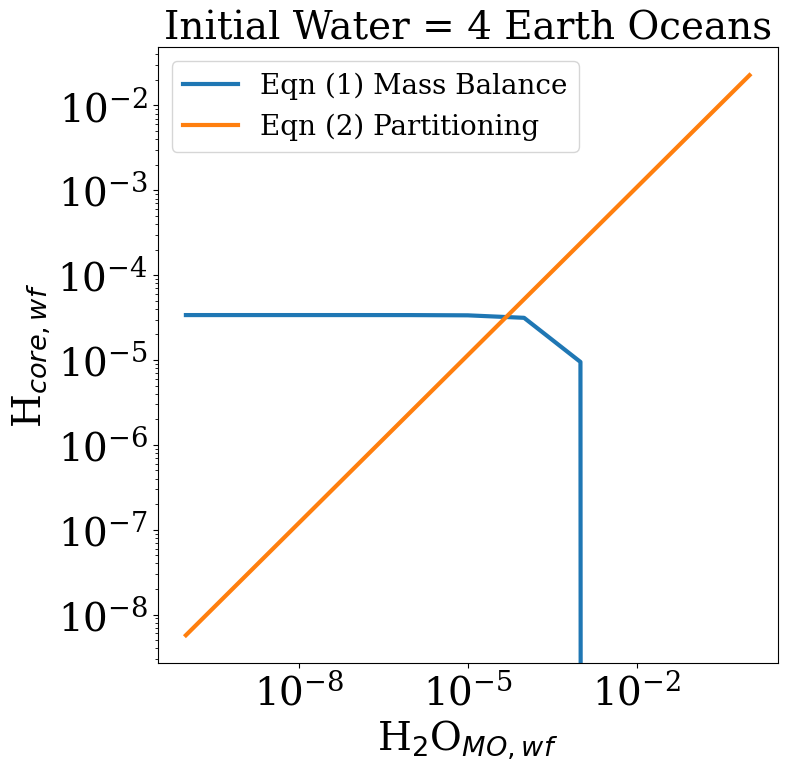

In [14]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
fig = plt.figure(figsize=(8,8))

Bulk_H2O_test = (4.*1.4e21)/(M_E)*100. #[wt%], BULK H2O ON PLANET

## Rearrange for one variable (say H_core_wf) and plot to confirm they intersect.
x_test = np.array([1.0e-10, 1.0e-9, 1.0e-8, 1.0e-7, 1.0e-6, 1.0e-5, 1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1, 1.0])

func1 = (1./900.*f_core)*(Bulk_H2O_test - ((1.-f_core)*x_test*100.))
func2 = (1./100.)*(np.exp(-7.42 + (1.22*np.log(P_eq)) + (101.8*(X_Na2O + X_K2O)) + (0.66*np.log(x_test*100.))))

plt.loglog(x_test, func1, linewidth=3, label='Eqn (1) Mass Balance')
plt.loglog(x_test, func2, linewidth=3, label='Eqn (2) Partitioning')
plt.xlabel(r'H$_2$O$_{MO,wf}$', fontsize=28)
plt.ylabel(r'H$_{core, wf}$', fontsize=28)
plt.title('Initial Water = 4 Earth Oceans', fontsize=28)
plt.legend(loc='best', fontsize=20)
#plt.savefig('Hpartition_intersection.pdf', bbox_inches='tight')

In [15]:
# Assume initial state is core (governed by some set core fraction), with the rest of planetary mass the magma
# ocean. With this in mind, we can calculate the mass of water in the MO. Since there is no loss (i.e., water
# partitions exactly between MO & core), we can then determine how much water is in the core.
M_init_array = ((1.-f_core)*M_E)*H2O_MO_wf_array #[kg of water in MO]
M_H2O_core = ((Bulk_H2O_array/100.)*M_E) - M_init_array #[kg of water in core]
print('Water in MO: ', M_init_array/1.4e21, 'Earth Oceans')
print('Water in core: ', M_H2O_core/1.4e21, 'Earth Oceans')
print('Total water: ', (M_init_array+M_H2O_core)/1.4e21, 'Earth Oceans')
print('Tested initial planetary Bulk H2O: ', Bulk_H2O_array/100.*M_E/1.4e21, 'Earth Oceans')

Water in MO:  [0.76365992 1.81266996 2.96999758 4.19460327] Earth Oceans
Water in core:  [1.23634008 2.18733004 3.03000242 3.80539673] Earth Oceans
Total water:  [2. 4. 6. 8.] Earth Oceans
Tested initial planetary Bulk H2O:  [2. 4. 6. 8.] Earth Oceans


## Set the initial amount of water in the MO, and calculate the initial concentration.

# Replacing R_c with r_tz,b and r_tz,t as MO moves up.

In [16]:
# Initial/constant parameters
# Water partition coefficient for upper/lower mantle
D_H2O = 0.001 #0.001 OR 0.1 (more water stored in mantle for larger D) #solid-liquid H2O distribution coefficient
# Water partition coefficient for transition zone --- MUCH higher
D_H2O_TZ = 0.1 # XXXX can try other values later once this works XXXX
#D = 0.2 #higher value "mimics" behaviour of BMO
R_p = Rp(M_E)/1000. #[km] #6400 km
R_c = Rc(M_E)/1000. #[km] #3000 km
rho = 3.0e3*1.0e9 #[kg/km^3] 
rho_MO = rho #density of MO [kg/km^3] 
#rho_m = rho

M = M_E #change here and throughout for different masses

# Saturation concentration & initial concentration of water in MO
C_sat = 0.001 #NOMINAL 0.1, OR 0.01, OR 0.1 (degassing earlier with lower C_sat) #[wt fraction]; H2O saturation limit of MO
#C_0 = 0.005 #[wt fraction]; initial H2O concentration of MO

# Initial mass of water in MO, and initial concentration in the MO.
## XXXXXX THIS VALUE HAS ALREADY BEEN SET ABOVE XXXXXX
#M_init_array = np.array([M_init_MO]) #[kg] ## XXXXXX THIS VALUE HAS ALREADY BEEN SET ABOVE XXXXXX
C_0_array = (3.*M_init_array)/(4.*np.pi*rho*(R_p**3. - R_c**3.))

# Required functions -- RECALL (r = R_p - d_MO(t))
def C_l(C_0, r, r_tz, D):
    
    return C_0*((R_p**3.-((r_tz)**3.))/(R_p**3.-r**3.))**(1.-D)

def C_s(C_0, r, r_tz, D):
    
    return D*C_l(C_0, r, r_tz, D)

def R_sat(C_0, r, r_tz, D):
    
    return (R_p**3. - ((R_p**3. - ((r_tz)**3.))/((C_sat/C_0)**(1./(1.-D)))))**(1./3.)

def M_MO_unsat(C_0, r, r_tz, D):
    
    return C_l(C_0, r, r_tz, D)*(4.*np.pi/3.)*rho_MO*(R_p**3. - r**3.)

def M_SM_unsat(C_0, r, r_tz, D):
    
    return C_0*(4.*np.pi/3.)*(rho_MO)*((R_p**3. - ((r_tz)**3.))**(1.-D))*\
            (((R_p**3. - ((r_tz)**3.))**D) - ((R_p**3. - r**3.)**D))

def M_MO_sat(r):
    
    return C_sat*(4.*np.pi/3.)*rho_MO*(R_p**3. - r**3.)

def M_SM_sat(C_0, r, r_tz, D):
    
    return M_SM_unsat(C_0, R_sat(C_0, r, r_tz, D), r_tz, D) + D*C_sat*(4.*np.pi/3.)*(rho_MO)*(r**3.-(R_sat(C_0, r, r_tz, D)**3.))

In [17]:
print('Water in MO: ', M_init_array/1.4e21, 'Earth Oceans')

Water in MO:  [0.76365992 1.81266996 2.96999758 4.19460327] Earth Oceans


In [18]:
def loss_rate_EL_MO(t, F_XUV, M): #[kg/s]
    
    # R_XUV = XUV deposition radius; LB15 set R_XUV = R_p for simplicity
    # M = planetary mass
    
    G = 6.67e-11
    eps_XUV = 0.1 #nominal; LB15 test 0.15-0.30
    
    return eps_XUV*np.pi*F_XUV*(Rp(M)**3.)/(G*M)

def loss_rate_DL_MO(M):
    
    g_p = g(M)*100. #[cm s^-2], to match the units of b
    k_B = 1.38e-23 #[m^2 kg s^-2 K^-1]; Boltzmann constant
    
    # Mole fractions of H & O (assuming all H2O is dissociated)
    X_H = 2./3.
    X_O = 1./3.
    
    m_H = 1.66e-27 #[kg]; mass of H atom
    m_O = 16.*m_H
        
    # Just take the thermospheric temperature as 400 K at all times, for now.
    b = 4.8e17*(400.**0.75) #[cm^-1 s^-1]
        
    return m_H*(np.pi*(Rp(M)**2.)*b*g_p*(m_O-m_H))/(k_B*400.*(1.+(X_O/X_H))) 
    
def f_loss_MO(t, M, a_orb, params1, params2, params3): 
    
    ### Note that the "check" for not losing more water than on the surface is in the MO loop itself
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
   # Planet always in a runaway greenhouse during MO, so loss is always EL.
    
    return loss_rate_EL_MO(t, F_XUV(t, M, a_orb, params1, params2, params3), M) #[kg/s]

In [19]:
## Orbital distances.
# Read in Kopparapu+(2013) HZ data, for different stellar hosts.

data = np.loadtxt('HZs.dat', skiprows=2)
T_eff_kopp = data[:,0] #[K]
# All below values give S_eff -- see Eqn.(2) of Kopparapu+(2013)
RV_kopp = data[:,1] #Recent Venus
RG_kopp = data[:,2] #Runaway Greenhouse
MG_kopp = data[:,3] #Maximum Greenhouse
EM_kopp = data[:,4] #Early Mars

def f_a_orb(t, M, T_eff_star, Lbol_Ls_star, params1, params2, params3):
    
    S_eff_RV = np.interp(T_eff_star, T_eff_kopp, RV_kopp)
    S_eff_RG = np.interp(T_eff_star, T_eff_kopp, RG_kopp)
    S_eff_MG = np.interp(T_eff_star, T_eff_kopp, MG_kopp)
    S_eff_EM = np.interp(T_eff_star, T_eff_kopp, EM_kopp)
    
    a_RV = (Lbol_Ls_star/S_eff_RV)**0.5 #[AU]
    a_RG = (Lbol_Ls_star/S_eff_RG)**0.5 #[AU]
    a_MG = (Lbol_Ls_star/S_eff_MG)**0.5 #[AU]
    a_EM = (Lbol_Ls_star/S_eff_EM)**0.5 #[AU]
    
    return a_RV, a_RG, a_MG, a_EM

In [20]:
# Stellar parameters required for MO sims
star_age, Lbol, Lbol_Ls_star, T_eff_star = hoststar(hostfile)

# Roughly find limits at t = 4.5 Gyr (~age of Earth)
T_eff_star_45 = np.interp(4.5e9*year, star_age, T_eff_star)
Lbol_Ls_star_45 = np.interp(4.5e9*year, star_age, Lbol_Ls_star)
        
a_RV, a_RG, a_MG, a_EM = f_a_orb(4.5e9*year, M_E, T_eff_star_45, Lbol_Ls_star_45, params1, params2, params3)
    
# For now, take runaway greenhouse and maximum greenhouse limits, and then the middle between them.
a_orb_array = np.array([a_RG, (a_RG+a_MG)/2., a_MG]) #np.array([(a_RG+a_MG)/2.])
a_orb_labels = ['Runaway_GH', 'Middle', 'Maximum_GH'] #['Middle']

In [21]:
# Calculate the runaway greenhouse duration, using the above orbital distances, 
# to be used as the magma ocean solidification timescale for each.

dt_MO = 2.0e3*year #2000 yr per timestep
M = M_E

RG_t_array = np.arange(0., 1.0e9*year, dt_MO) #[s]

tau_RG_array = np.zeros(len(a_orb_array)) #[s]
exit_RG_array = np.zeros(len(a_orb_array)) #index

for jdx in range(0, len(a_orb_array)):
    
    RG_TOA_flux_array = S_0(RG_t_array, M, a_orb_array[jdx]*1.496e11, params1, params2, params3)

    for idx in range(0, len(RG_t_array)):
    
        if RG_TOA_flux_array[idx]/4. < 325./(1.-alb):
        
            tau_RG_array[jdx] = RG_t_array[idx]
            exit_RG_array[jdx] = idx
            break
        
print(tau_RG_array/year/1.0e9, 'Gyr')

[0.33503  0.109778 0.048248] Gyr


In [22]:
# Set the duration of the MO to be the same as the duration of RG.
tau_MO_array = tau_RG_array
# tau_RG is tied to a given orbital distance!!!!

# M_init_array is the TOTAL initial water inventory, which starts compltely dissolved in the MO, but partitions
# between MO and core based on the mass balance/partitioning equations above.
M_init_file = np.array([2., 4., 6., 8.]) #[Earth Oceans]

In [23]:
# Loop to determine whether or not MO is saturated & degas an atmosphere if it is
dt_MO = 2.0e3*year #2000 yr per timestep
M = M_E

# Arrays to save final water inventories at end of MO simulation.
W_m_init_array = np.zeros((len(M_init_array), len(a_orb_array)))
W_s_init_array = np.zeros((len(M_init_array), len(a_orb_array)))

# Path to save MO simulations to file. CHANGE THIS WHEN RUNNING YOUR OWN SIMULATIONS!
save_path = '/Users/admin/Desktop/Heising-Simons_H-Partitioning/'
# Loop over water inventories.
for kdx in range(0, len(M_init_array)): 
        
    # Loop over orbital distances + RG durations, tied together.
    for jdx in range(0,len(a_orb_array)):
            
        t_MO_array = np.arange(0., (tau_MO_array[jdx]+dt_MO), dt_MO) # 50 Myr; equivalent to MO solidification timescale
        r_array = R_p - d_MO(t_MO_array, tau_MO_array[jdx], M)
        d_MO_array = d_MO(t_MO_array, tau_MO_array[jdx], M)
        
        # Find the corresponding indices for transition from lower mantle to TZ (~660 km), and TZ to upper mantle (~410 km). 
        idx_tz_b = np.max((np.where(d_MO_array > 660)))
        idx_tz_t = np.min((np.where(d_MO_array < 410)))
        
        save_file = 'core_MO_partition_transitionzone_MO_only_loss_M_init-' + str(M_init_file[kdx]) + 'TO_' + str(a_orb_labels[jdx]) + '.txt'
            
        filename = os.path.join(save_path, save_file)
        f = open(filename, 'w')

        # 4 TOTAL reservoirs, for mass balance throughout
        M_MO_array = np.zeros(len(r_array)) #magma ocean [kg]
        M_SM_array = np.zeros(len(r_array)) #solid mantle [kg]
        M_atmo_array = np.zeros(len(r_array)) #atmosphere [kg]
        M_lost_array = np.zeros(len(r_array)) #space "sink" for lost water [kg]
        EL_loss_MO_array = np.zeros(len(r_array)) #energy-limited loss rate [kg/s]
        DL_loss_MO_array = np.zeros(len(r_array)) #diffusion-limited loss rate [kg/s]
        loss_MO_array = np.zeros(len(r_array)) #actual loss rate (EL during MO; DL otherwise) [kg/s]
        TOA_flux_MO_array = np.zeros(len(r_array)) #top-of-atmosphere flux [W/m^2]
        a_orb = a_orb_array[jdx]*1.496e11 #orbital distance [m]

        # Track MO temperature as a function of r/t.
        T_MO_array = np.zeros(len(t_MO_array)) #[K]

        # Keep track of the total water inventory, for mass balance purposes throughout.
        M_total = M_init_array[kdx] #[kg]
        
        # Initial concentration; needs to be altered from array if MO begins simulation saturated.
        C_initial = C_0_array[kdx] #concentration; unitless
        
        # First, need to check if MO holds MORE water than saturation limit; if it does, degas the excess into
        # atmosphere FIRST before running simulations.
        if C_initial > C_sat:
            
            MO_excess = (C_initial-C_sat)*(4.*np.pi*rho*(R_p**3. - R_c**3.))/3.
            
            M_MO_array[0] = M_total - MO_excess
            M_SM_array[0] = 0.
            M_atmo_array[0] = MO_excess
            
            C_initial = (3.*M_MO_array[0])/(4.*np.pi*rho*(R_p**3. - R_c**3.))
            
        else:
        
            # Set initial parameters; all water (that wasn't partitioned into core) dissolved in MO:
            M_MO_array[0] = M_total
            M_SM_array[0] = 0.
            M_atmo_array[0] = 0.
        
        EL_loss_MO_array[0] = loss_rate_EL_MO(t_MO_array[0], F_XUV(t_MO_array[0], M, a_orb, params1, params2, params3), M_E)
        DL_loss_MO_array[0] = loss_rate_DL_MO(M)
        loss_MO_array[0] = f_loss_MO(t_MO_array[0], M, a_orb, params1, params2, params3)
        TOA_flux_MO_array[0] = S_0(t_MO_array[0], M, a_orb, params1, params2, params3)
        T_MO_array[0] = T_MO(t_MO_array[0], tau_MO_array[jdx], M, params1, params2, params3)
            
        f.write(str(t_MO_array[0]) + '\t' + str(r_array[0]) + '\t' + str(T_MO_array[0]) + '\t' + str(M_MO_array[0]) +'\t' + \
                str(M_SM_array[0]) + '\t' + str(M_atmo_array[0]) + '\t' + str(EL_loss_MO_array[0]) + '\t' + \
                str(DL_loss_MO_array[0]) + '\t' +str(loss_MO_array[0]) + '\t' + str(TOA_flux_MO_array[0]) + '\n')
        
        for idx in range(1,len(r_array)):
        
            # Need to track the current concentration when the partition coefficient changes at base of TZ and at top.
            # This variable should be updated based on where we are in the solidifying mantle.
            
            EL_loss_MO_array[idx] = loss_rate_EL_MO(t_MO_array[idx], F_XUV(t_MO_array[idx], M, a_orb, params1, params2, params3), M_E)
            DL_loss_MO_array[idx] = loss_rate_DL_MO(M)
            loss_MO_array[idx] = f_loss_MO(t_MO_array[idx], M, a_orb, params1, params2, params3)
            TOA_flux_MO_array[idx] = S_0(t_MO_array[idx], M, a_orb, params1, params2, params3)
            T_MO_array[idx] = T_MO(t_MO_array[idx], tau_MO_array[jdx], M, params1, params2, params3)
        
            # If statements to determine partition coefficient, D.
            #Upper/lower mantle has some D; transition zone (depth of 410 km to 660 km) has a much higher value.
            # XXXXX Try with only a SINGLE transition first. XXXXX
                
            # If statements to update D_H2O and C_current when moving between reservoirs.
            if idx <= idx_tz_b: #lower mantle, below transition zone
                
                C_current = C_initial
                D = D_H2O
                r_tz = R_c
                
            #else: #transition zone up to surface
            elif idx >= idx_tz_b and idx <= idx_tz_t: #inside transition zone
                
                C_current = (3.*M_MO_array[idx_tz_b])/(4.*np.pi*rho*(R_p**3. - ((r_array[idx_tz_b])**3.)))
                D = D_H2O_TZ
                r_tz = r_array[idx_tz_b]
                
            else: #upper mantle, above transition zone
                
                C_current = (3.*M_MO_array[idx_tz_t])/(4.*np.pi*rho*(R_p**3. - ((r_array[idx_tz_t])**3.)))
                D = D_H2O
                r_tz = r_array[idx_tz_t]
            
            #MO undersaturated with water, i.e., r <= R_sat
            if r_array[idx] <= R_sat(C_current, r_array[idx], r_tz, D):
        
                M_MO_array[idx] = M_MO_unsat(C_current, r_array[idx], r_tz, D)
        
                M_SM_array[idx] = M_SM_unsat(C_current, r_array[idx], r_tz, D)
        
                M_atmo_array[idx] = 0.
        
            # MO saturated/supersaturated with water (r > R_sat); atmosphere forms    
            else: #r_array[idx] > R_sat()
        
                M_MO_array[idx] = M_MO_sat(r_array[idx])
        
                M_SM_array[idx] = M_SM_sat(C_current, r_array[idx], r_tz, D)
        
                M_atmo_array[idx] = M_total - M_SM_sat(C_current, r_array[idx], r_tz, D) - M_MO_sat(r_array[idx]) - M_lost_array[idx-1]
        
                # Now add loss:
                if M_atmo_array[idx] <= (loss_MO_array[idx]*dt_MO):
            
                    M_lost_array[idx] = M_lost_array[idx-1] + M_atmo_array[idx]
                    M_atmo_array[idx] = 0.  #no water in atmosphere; all lost to space
                        
                else: #M_atmo_array[idx] > (loss_MO_array[idx]*dt_MO)
                    
                    M_atmo_array[idx] = M_atmo_array[idx] - (loss_MO_array[idx]*dt_MO)
                    M_lost_array[idx] = M_lost_array[idx-1] + (loss_MO_array[idx]*dt_MO)

            # Comment the below lines back in, to write results to file.
            f.write(str(t_MO_array[idx]) + '\t' + str(r_array[idx]) + '\t' + str(T_MO_array[idx]) + '\t' + str(M_MO_array[idx]) +'\t' + \
                str(M_SM_array[idx]) + '\t' + str(M_atmo_array[idx]) + '\t' + str(EL_loss_MO_array[idx]) + '\t' + \
                str(DL_loss_MO_array[idx]) + '\t' +str(loss_MO_array[idx]) + '\t' + str(TOA_flux_MO_array[idx]) + '\n')
                    
        W_m_init_array[kdx, jdx] = M_SM_array[-1]
        W_s_init_array[kdx, jdx] = M_atmo_array[-1]
            
        f.close()

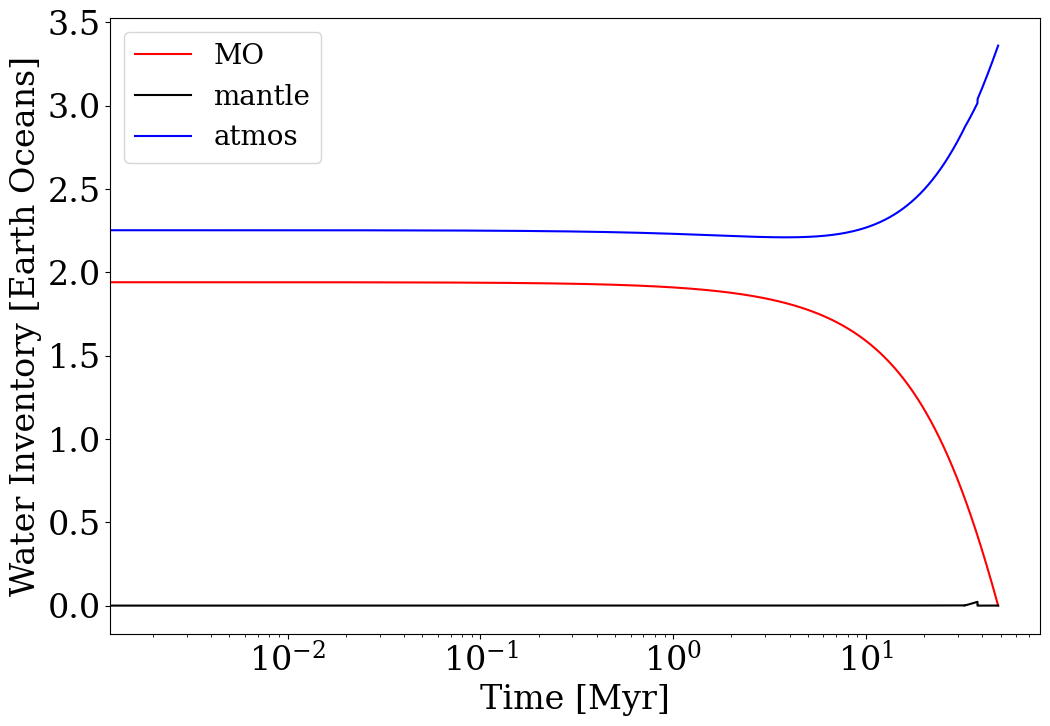

In [24]:
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
fig = plt.figure(figsize=(12,8))

plt.semilogx(t_MO_array/year/1.0e6, M_MO_array/1.4e21, color='r', label='MO')
plt.semilogx(t_MO_array/year/1.0e6, M_SM_array/1.4e21, color='k', label='mantle')
plt.semilogx(t_MO_array/year/1.0e6, M_atmo_array/1.4e21, color='b', label='atmos')
plt.xlabel('Time [Myr]', fontsize=24)
plt.ylabel('Water Inventory [Earth Oceans]', fontsize=24)
plt.legend(loc='best', fontsize=20)
#plt.savefig('TZ_Partition_Test.pdf', bbox_inches='tight')

/var/folders/_f/vkbk1bkd2jg3l_6p0xcff_rc0000gn/T/ipykernel_71331/1914853185.py:19: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([t_MO_array[0]/year/1.0e6, t_MO_array[-1]/year/1.0e6])
/var/folders/_f/vkbk1bkd2jg3l_6p0xcff_rc0000gn/T/ipykernel_71331/1914853185.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels((round(tau_RG_array[2]/year/1.0e6,2))-plt.gca().get_xticks())


[Text(0.0001, 0, '48.2499'),
 Text(0.001, 0, '48.249'),
 Text(0.01, 0, '48.24'),
 Text(0.1, 0, '48.15'),
 Text(1.0, 0, '47.25'),
 Text(10.0, 0, '38.25'),
 Text(100.0, 0, '-51.75'),
 Text(1000.0, 0, '-951.75')]

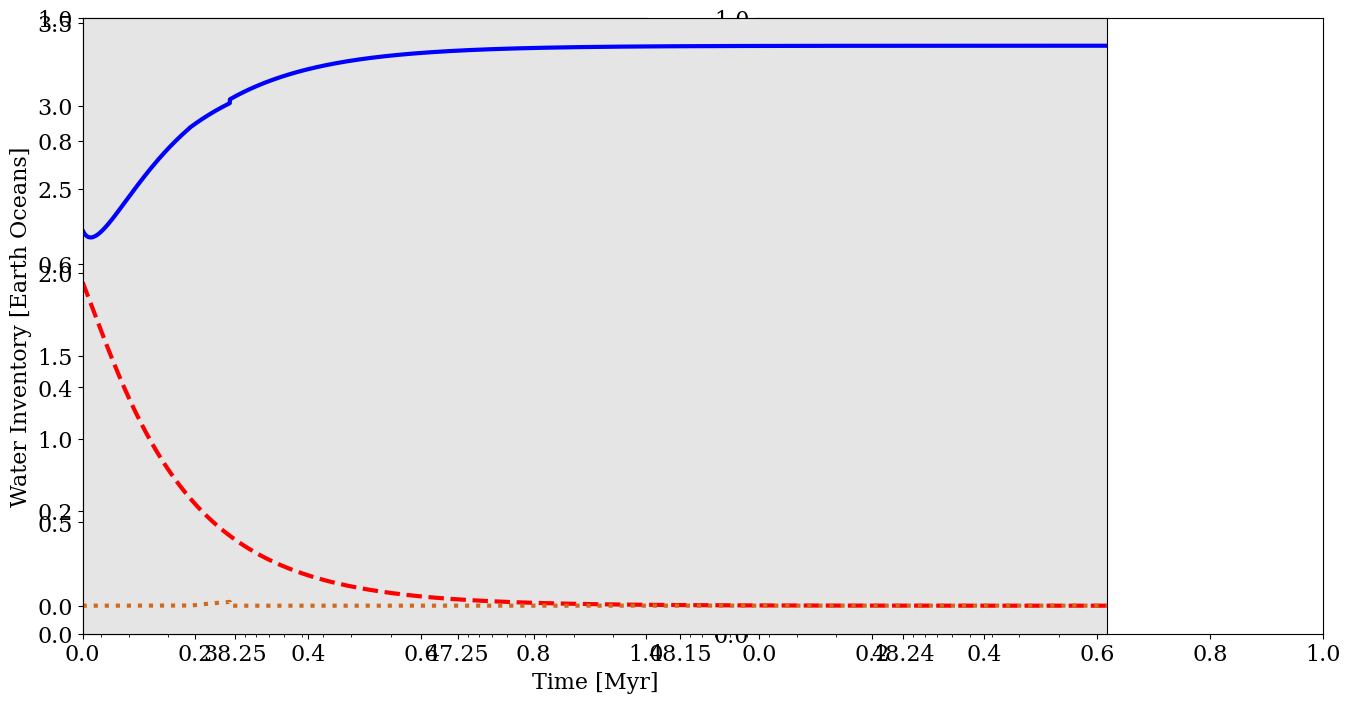

In [25]:
from matplotlib import gridspec
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(16,8))
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]

gs = gridspec.GridSpec(1, 2, width_ratios=[10, 1])

ax1 = plt.subplot(gs[0])
plt.plot(t_MO_array[::-1]/year/1.0e6, M_atmo_array/1.4e21, linewidth=3, color='b', linestyle='-', label='Atmosphere')
plt.plot(t_MO_array[::-1]/year/1.0e6, M_MO_array/1.4e21, linewidth=3, color='r', linestyle='--', label='Magma Ocean')
#plt.plot(t_MO_array[::-1]/year/1.0e6, (M_MO_array+M_SM_array)/1.4e21, linewidth=3, color='r', linestyle='--', label='Magma Ocean')
plt.plot(t_MO_array[::-1]/year/1.0e6, M_SM_array/1.4e21, linewidth=3, color='chocolate', linestyle=':', label='Solid Mantle')
ax1.set_xscale('log')
plt.axvspan(t_MO_array[0]/year/1.0e6, t_MO_array[-1]/year/1.0e6, alpha=0.2, color='grey')
plt.xlim([t_MO_array[0]/year/1.0e6, t_MO_array[-1]/year/1.0e6])
plt.gca().invert_xaxis()
plt.xlabel('Time [Myr]', fontsize=16)
plt.ylabel('Water Inventory [Earth Oceans]', fontsize=16)
plt.gca().set_xticklabels((round(tau_RG_array[2]/year/1.0e6,2))-plt.gca().get_xticks())
#plt.savefig('TEST_tau_MO=tau_RG.pdf', bbox_inches='tight')

In [27]:
# DEBUGGING

print("Initial: SM, atmo, MO, lost to space")
print(M_SM_array[0]/1.4e21)
print(M_atmo_array[0]/1.4e21)
print(M_MO_array[0]/1.4e21)
print(M_lost_array[0]/1.4e21)

print("Final: SM, atmo, MO, lost to space")
print(M_SM_array[-1]/1.4e21)
print(M_atmo_array[-1]/1.4e21)
print(M_MO_array[-1]/1.4e21)
print(M_lost_array[-1]/1.4e21)

print("Final total water (should be =M_MO[0] if loss to space included): ")
print((M_MO_array[-1]+M_SM_array[-1]+M_atmo_array[-1]+M_lost_array[-1])/1.4e21)

#print("M_total (with loss) (also <6 TO): ")
#print(M_total/1.4e21)

#print('Total water lost: ')
#print(M_lost/1.4e21)

Initial: SM, atmo, MO, lost to space
0.0
2.2533432563135536
1.9412600153796977
0.0
Final: SM, atmo, MO, lost to space
0.00041990525083344184
3.361129761656272
0.0
0.8330536047861459
Final total water (should be =M_MO[0] if loss to space included): 
4.194603271693252


In [28]:
# Read in MO results (pre-cycling).

save_path = '/Users/admin/Desktop/Heising-Simons_H-Partitioning/'

#tolerance = 1.29e16 #[kg]; if below this, set water = 0 --> DESICCATED

# Initial water content in each reservoir
M_MO_initial_all = np.zeros((len(M_init_array), len(a_orb_array)))
M_SM_initial_all = np.zeros((len(M_init_array), len(a_orb_array)))
M_atmo_initial_all = np.zeros((len(M_init_array), len(a_orb_array)))

# Final water content in each reservoir
M_MO_final_all = np.zeros((len(M_init_array), len(a_orb_array)))
M_SM_final_all = np.zeros((len(M_init_array), len(a_orb_array)))
M_atmo_final_all = np.zeros((len(M_init_array), len(a_orb_array)))

# Initial and final mantle temperatures, if needed.
T_MO_initial_all = np.zeros((len(M_init_array), len(a_orb_array)))
T_MO_final_all = np.zeros((len(M_init_array), len(a_orb_array)))

# How many reach exactly zero in one/both reservoir/s at the end?
#W_m_zero_count_MO_all = 0.
#W_s_zero_count_MO_all = 0.
#both_zero_count_MO_all = 0.

for jdx in range(0, len(a_orb_array)):
    
    # Need length of data for the following arrays.
    save_file = 'core_MO_partition_transitionzone_MO_only_loss_M_init-2.0TO_' + str(a_orb_labels[jdx]) + '.txt'    
    filename = os.path.join(save_path, save_file)
    tmp_data = np.loadtxt(filename)

    # Time array; same for all with the same orbital distance.
    t_MO_array = tmp_data[:, 0]

    # Overall evolution path for each reservoir & mantle temperature & surface temperature.
    M_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))
    M_SM_paths = np.zeros((len(M_init_array),len(tmp_data)))
    M_atmo_paths = np.zeros((len(M_init_array),len(tmp_data)))
    r_sol_paths = np.zeros((len(M_init_array),len(tmp_data)))
    T_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))
    TOA_flux_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))
    #TOA_flux_paths = np.zeros((len(tau_MO_array), len(M_init_array),len(tmp_data)))

    # Overall evolution path for degassing and regassing rates.
    loss_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))
    EL_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))
    DL_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))
    
    for kdx in range(0, len(M_init_array)):
                
        # Read in data files for each model, and save them as the evolutionary path. 
        save_file = 'core_MO_partition_transitionzone_MO_only_loss_M_init-' + str(M_init_file[kdx]) + 'TO_' + str(a_orb_labels[jdx]) + '.txt'
            
        print(save_file)
        filename = os.path.join(save_path, save_file)
        tmp_data = np.loadtxt(filename)
        r_sol_paths[kdx,:] = tmp_data[:,1]
        T_MO_paths[kdx:] = tmp_data[:,2]
        M_MO_paths[kdx,:] = tmp_data[:,3]
        M_SM_paths[kdx,:] = tmp_data[:,4]
        M_atmo_paths[kdx,:] = tmp_data[:,5]
        EL_MO_paths[kdx,:] = tmp_data[:,6]
        DL_MO_paths[kdx,:] = tmp_data[:,7]
        loss_MO_paths[kdx,:] = tmp_data[:,8]
        TOA_flux_MO_paths[kdx,:] = tmp_data[:,9]

        # Save initial and final values to corresponding arrays.
        M_MO_initial_all[kdx, jdx] = M_MO_paths[kdx,0]
        M_SM_initial_all[kdx, jdx] = M_SM_paths[kdx,0]
        M_atmo_initial_all[kdx, jdx] = M_atmo_paths[kdx,0]
    
        T_MO_initial_all[kdx, jdx] = T_MO_paths[kdx,0]
        T_MO_final_all[kdx, jdx] = T_MO_paths[kdx,-1]
    
        # Check for zeros.     
        #if W_m_paths[kdx,ldx,-1] <= tolerance and W_s_paths[kdx,ldx,-1] <= tolerance:
         #    both_zero_count_all = both_zero_count_all + 1.
            #W_m_final[jdx,kdx] = 0.
            #W_s_final[jdx,kdx] = 0.
        #elif W_m_paths[kdx,ldx,-1] <= tolerance:
        #    W_m_zero_count_all = W_m_zero_count_all + 1.
            #W_m_final[jdx,kdx] = 0.
            #W_s_final[jdx,kdx] = W_s_paths[jdx,kdx,-1]
        #elif W_s_paths[kdx,ldx,-1] <= tolerance:
        #    W_s_zero_count_all = W_s_zero_count_all + 1.
            #W_s_final[jdx,kdx] = 0.
            #W_m_final[jdx,kdx] = W_m_paths[jdx,kdx,-1]
        #else: #neither is zero; save normally
        #    W_m_final_all[jdx, kdx, ldx] = W_m_paths[kdx,ldx,-1]
        #    W_s_final_all[jdx, kdx, ldx] = W_s_paths[kdx,ldx,-1]
        
        M_MO_final_all[kdx, jdx] = M_MO_paths[kdx,-1]
        M_SM_final_all[kdx, jdx] = M_SM_paths[kdx,-1]     
        M_atmo_final_all[kdx, jdx] = M_atmo_paths[kdx,-1]
            
#print('Zero water: ', 'W_m: ', W_m_zero_count_all, 'W_s: ', W_s_zero_count_all, 'both: ', both_zero_count_all)

core_MO_partition_transitionzone_MO_only_loss_M_init-2.0TO_Runaway_GH.txt
core_MO_partition_transitionzone_MO_only_loss_M_init-4.0TO_Runaway_GH.txt
core_MO_partition_transitionzone_MO_only_loss_M_init-6.0TO_Runaway_GH.txt
core_MO_partition_transitionzone_MO_only_loss_M_init-8.0TO_Runaway_GH.txt
core_MO_partition_transitionzone_MO_only_loss_M_init-2.0TO_Middle.txt
core_MO_partition_transitionzone_MO_only_loss_M_init-4.0TO_Middle.txt
core_MO_partition_transitionzone_MO_only_loss_M_init-6.0TO_Middle.txt
core_MO_partition_transitionzone_MO_only_loss_M_init-8.0TO_Middle.txt
core_MO_partition_transitionzone_MO_only_loss_M_init-2.0TO_Maximum_GH.txt
core_MO_partition_transitionzone_MO_only_loss_M_init-4.0TO_Maximum_GH.txt
core_MO_partition_transitionzone_MO_only_loss_M_init-6.0TO_Maximum_GH.txt
core_MO_partition_transitionzone_MO_only_loss_M_init-8.0TO_Maximum_GH.txt


### Individual read-ins for a given orbital distance.

In [29]:
# Choose which solidification timescale will be read-in.
# TRY FOR ONLY A SINGLE SOLIDIFICATION TIMESCALE, TO ALLOW PLOTTING. -- tau_MO = 10 Myr, 50 Myr, or 100 Myr
orb_idx = 0 #0-2
print(a_orb_labels[orb_idx])

Runaway_GH


In [30]:
# Read in MO results (pre-cycling).

save_path = '/Users/admin/Desktop/Heising-Simons_H-Partitioning/'
#tolerance = 1.29e16 #[kg]; if below this, set water = 0 --> DESICCATED

# Initial water content in each reservoir
M_MO_initial = np.zeros(len(M_init_array))
M_SM_initial = np.zeros(len(M_init_array))
M_atmo_initial = np.zeros(len(M_init_array))

# Final water content in each reservoir
M_MO_final = np.zeros(len(M_init_array))
M_SM_final = np.zeros(len(M_init_array))
M_atmo_final = np.zeros(len(M_init_array))

# Initial and final mantle temperatures, if needed.
T_MO_initial = np.zeros(len(M_init_array))
T_MO_final = np.zeros(len(M_init_array))
    
# Need length of data for the following arrays.
save_file = 'core_MO_partition_transitionzone_MO_only_loss_M_init-2.0TO_' + str(a_orb_labels[orb_idx]) + '.txt'    
filename = os.path.join(save_path, save_file)
tmp_data = np.loadtxt(filename)

# Time array; same for all.
t_MO_array = tmp_data[:, 0]

# Overall evolution path for each reservoir & mantle temperature & surface temperature.
M_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))
M_SM_paths = np.zeros((len(M_init_array),len(tmp_data)))
M_atmo_paths = np.zeros((len(M_init_array),len(tmp_data)))
#r_sol_paths = np.zeros((len(M_init_array),len(tmp_data)))
T_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))
TOA_flux_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))

loss_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))
EL_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))
DL_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))
    
for kdx in range(0, len(M_init_array)):
                
    # Read in data files for each model, and save them as the evolutionary path. 
    save_file = 'core_MO_partition_transitionzone_MO_only_loss_M_init-' + str(M_init_file[kdx]) + 'TO_' + str(a_orb_labels[orb_idx]) + '.txt'
        
    print(save_file)
    filename = os.path.join(save_path, save_file)
    tmp_data = np.loadtxt(filename)
#    r_sol_paths[kdx,:] = tmp_data[:,1]
    T_MO_paths[kdx,:] = tmp_data[:,2]
    M_MO_paths[kdx,:] = tmp_data[:,3]
    M_SM_paths[kdx,:] = tmp_data[:,4]
    M_atmo_paths[kdx,:] = tmp_data[:,5]
    EL_MO_paths[kdx,:] = tmp_data[:,6]
    DL_MO_paths[kdx,:] = tmp_data[:,7]
    loss_MO_paths[kdx,:] = tmp_data[:,8]
    TOA_flux_MO_paths[kdx,:] = tmp_data[:,9]

    # Save initial and final values to corresponding arrays.
    M_MO_initial[kdx] = M_MO_paths[kdx,0]
    M_SM_initial[kdx] = M_SM_paths[kdx,0]
    M_atmo_initial[kdx] = M_atmo_paths[kdx,0]
    
    T_MO_initial[kdx] = T_MO_paths[kdx,0]
    T_MO_final[kdx] = T_MO_paths[kdx,-1]
    
    # Check for zeros.     
    #if W_m_paths[kdx,ldx,-1] <= tolerance and W_s_paths[kdx,ldx,-1] <= tolerance:
    #    both_zero_count_all = both_zero_count_all + 1.
        #W_m_final[jdx,kdx] = 0.
        #W_s_final[jdx,kdx] = 0.
    #elif W_m_paths[kdx,ldx,-1] <= tolerance:
    #    W_m_zero_count_all = W_m_zero_count_all + 1.
        #W_m_final[jdx,kdx] = 0.
        #W_s_final[jdx,kdx] = W_s_paths[jdx,kdx,-1]
    #elif W_s_paths[kdx,ldx,-1] <= tolerance:
    #    W_s_zero_count_all = W_s_zero_count_all + 1.
        #W_s_final[jdx,kdx] = 0.
        #W_m_final[jdx,kdx] = W_m_paths[jdx,kdx,-1]
    #else: #neither is zero; save normally
    #    W_m_final_all[jdx, kdx, ldx] = W_m_paths[kdx,ldx,-1]
    #    W_s_final_all[jdx, kdx, ldx] = W_s_paths[kdx,ldx,-1]
        
    M_MO_final[kdx] = M_MO_paths[kdx,-1]
    M_SM_final[kdx] = M_SM_paths[kdx,-1]     
    M_atmo_final[kdx] = M_atmo_paths[kdx,-1]
            
#print('Zero water: ', 'W_m: ', W_m_zero_count_all, 'W_s: ', W_s_zero_count_all, 'both: ', both_zero_count_all)

core_MO_partition_transitionzone_MO_only_loss_M_init-2.0TO_Runaway_GH.txt
core_MO_partition_transitionzone_MO_only_loss_M_init-4.0TO_Runaway_GH.txt
core_MO_partition_transitionzone_MO_only_loss_M_init-6.0TO_Runaway_GH.txt
core_MO_partition_transitionzone_MO_only_loss_M_init-8.0TO_Runaway_GH.txt


## Plot time-dependent figure of the MO stage, including water partitioned into core.

In [31]:
init_idx = 2 #0-3; initial surface water: {2,4,6,8}

#t_MO_array already defined
T_MO_array = T_MO_paths[init_idx,:]
M_MO_array = M_MO_paths[init_idx,:]
M_SM_array = M_SM_paths[init_idx,:]
M_atmo_array = M_atmo_paths[init_idx,:]
r_array = r_sol_paths[init_idx,:]

In [32]:
print(Bulk_H2O_array[init_idx]/100.*M_E)
print(M_MO_array[0])

8.4e+21
2.7177640215315764e+21


/var/folders/_f/vkbk1bkd2jg3l_6p0xcff_rc0000gn/T/ipykernel_71331/2086562921.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([t_MO_array[0]/year/1.0e6, t_MO_array[-1]/year/1.0e6])
/var/folders/_f/vkbk1bkd2jg3l_6p0xcff_rc0000gn/T/ipykernel_71331/2086562921.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels((round(tau_RG_array[orb_idx]/year/1.0e6,2))-plt.gca().get_xticks())


Text(0.5, 1.0, 'Initial Bulk H2O = 6 Earth Oceans')

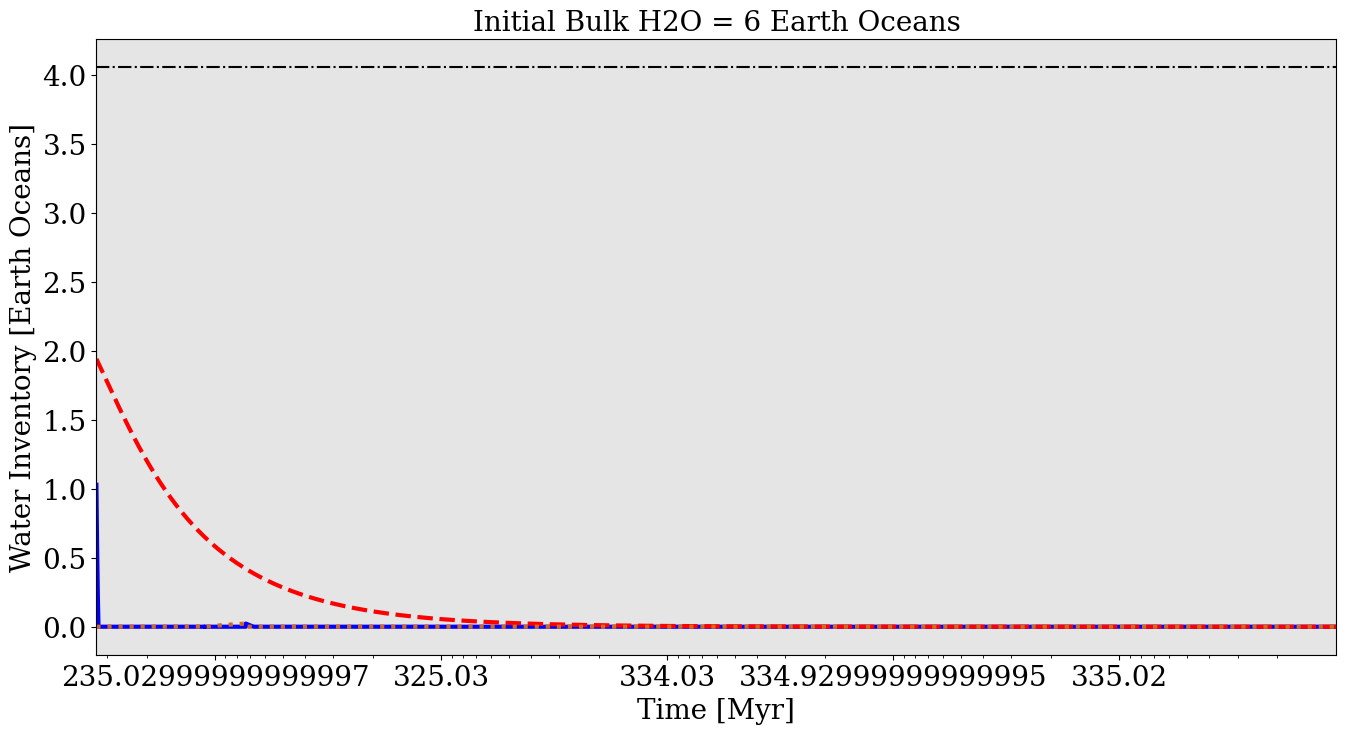

In [33]:
from matplotlib import gridspec
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,1,1)

#gs = gridspec.GridSpec(1, 2, width_ratios=[10, 1])

#ax1 = plt.subplot(gs[0])
plt.axhline(y=(((Bulk_H2O_array[init_idx]/100.*M_E)-M_MO_array[0])/1.4e21), color='k', linestyle='-.', label='Core')
plt.plot(t_MO_array[::-1]/year/1.0e6, M_atmo_array/1.4e21, linewidth=3, color='b', linestyle='-', label='Atmosphere')
plt.plot(t_MO_array[::-1]/year/1.0e6, M_MO_array/1.4e21, linewidth=3, color='r', linestyle='--', label='Magma Ocean')
#plt.plot(t_MO_array[::-1]/year/1.0e6, (M_MO_array+M_SM_array)/1.4e21, linewidth=3, color='r', linestyle='--', label='Magma Ocean')
plt.plot(t_MO_array[::-1]/year/1.0e6, M_SM_array/1.4e21, linewidth=3, color='chocolate', linestyle=':', label='Solid Mantle')
ax.set_xscale('log')
plt.axvspan(t_MO_array[0]/year/1.0e6, t_MO_array[-1]/year/1.0e6, alpha=0.2, color='grey')
plt.xlim([t_MO_array[0]/year/1.0e6, t_MO_array[-1]/year/1.0e6])
plt.gca().invert_xaxis()
plt.xlabel('Time [Myr]', fontsize=20)
plt.ylabel('Water Inventory [Earth Oceans]', fontsize=20)
plt.gca().set_xticklabels((round(tau_RG_array[orb_idx]/year/1.0e6,2))-plt.gca().get_xticks())
plt.title('Initial Bulk H2O = %d Earth Oceans' % (Bulk_H2O_array[init_idx]/100.*M_E/1.4e21), fontsize=20)
#plt.savefig('TEST_tau_MO=tau_RG.pdf', bbox_inches='tight')

## Try a non-reversed log plot for comparison.

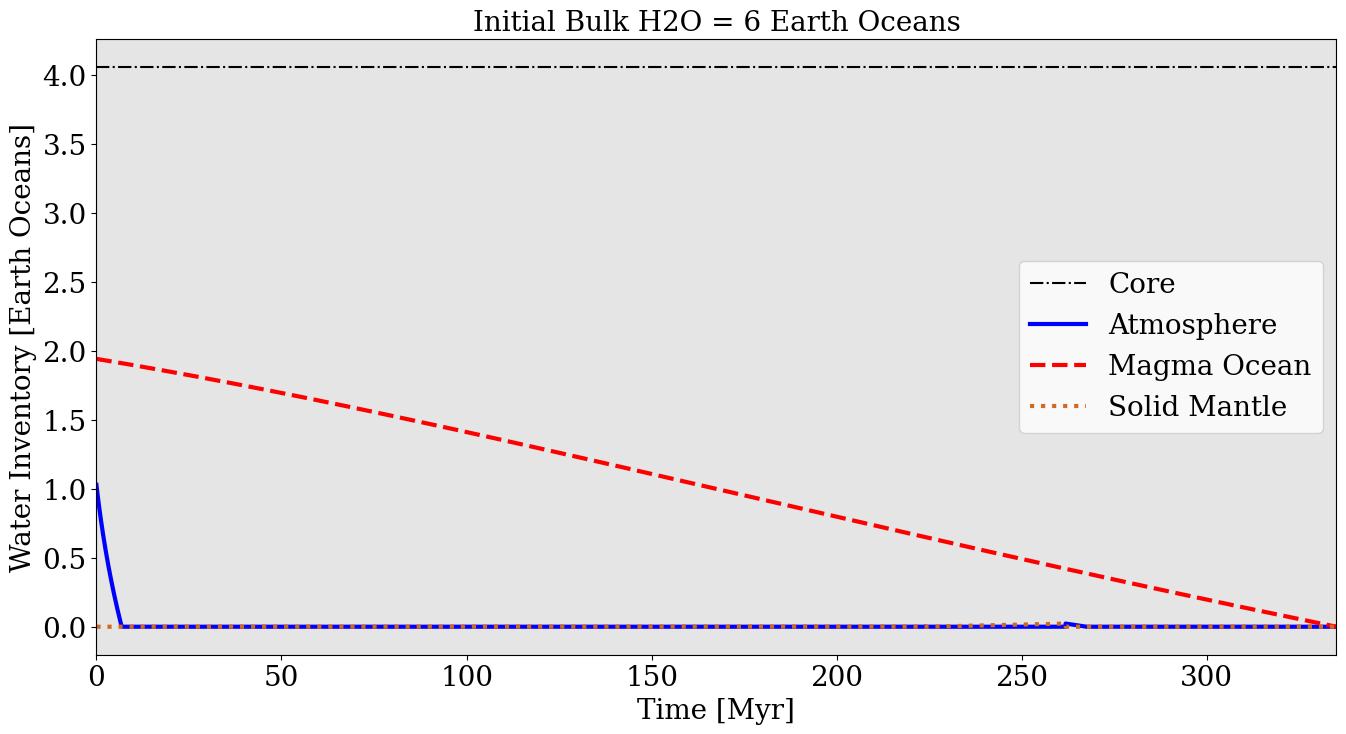

In [34]:
from matplotlib import gridspec
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,1,1)

#gs = gridspec.GridSpec(1, 2, width_ratios=[10, 1])

#ax1 = plt.subplot(gs[0])
plt.axhline(y=(((Bulk_H2O_array[init_idx]/100.*M_E)-M_MO_array[0])/1.4e21), color='k', linestyle='-.', label='Core')
plt.plot(t_MO_array/year/1.0e6, M_atmo_array/1.4e21, linewidth=3, color='b', linestyle='-', label='Atmosphere')
plt.plot(t_MO_array/year/1.0e6, M_MO_array/1.4e21, linewidth=3, color='r', linestyle='--', label='Magma Ocean')
#plt.plot(t_MO_array/year/1.0e6, (M_MO_array+M_SM_array)/1.4e21, linewidth=3, color='r', linestyle='--', label='Magma Ocean')
plt.plot(t_MO_array/year/1.0e6, M_SM_array/1.4e21, linewidth=3, color='chocolate', linestyle=':', label='Solid Mantle')
#ax.set_yscale('log')
plt.axvspan(t_MO_array[0]/year/1.0e6, t_MO_array[-1]/year/1.0e6, alpha=0.2, color='grey')
plt.xlim([t_MO_array[0]/year/1.0e6, t_MO_array[-1]/year/1.0e6])
#plt.gca().invert_xaxis()
plt.xlabel('Time [Myr]', fontsize=20)
plt.ylabel('Water Inventory [Earth Oceans]', fontsize=20)
#plt.gca().set_xticklabels((round(tau_RG_array[orb_idx]/year/1.0e6,2))-plt.gca().get_xticks())
plt.title('Initial Bulk H2O = %d Earth Oceans' % (Bulk_H2O_array[init_idx]/100.*M_E/1.4e21), fontsize=20)
plt.legend(loc='best', fontsize=20)
#plt.savefig('CorePartitioning_TransitionZone_InnerHZ_6TO.pdf', bbox_inches='tight')
#plt.savefig('CorePartitioning_TransitionZone_InnerHZ_6TO_logy.pdf', bbox_inches='tight')

## Everything seems to work so far. Let's make a plot showing how water partitions between MO and core for a given initial planetary water content, all else remaining the same (i.e., assuming an Earth-twin).

In [35]:
#Bulk_H2O is in [wt.%]
Bulk_H2O_array_plot = np.array([1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 12., 14., 16., 18., 20., 24., 28., 32., 36., 40., 48., 56., 64.])*(1.4e21/M_E*100.)

x0_guess_array_plot = np.zeros(len(Bulk_H2O_array_plot))
x1_guess_array_plot = np.zeros(len(Bulk_H2O_array_plot))

H2O_MO_wf_array_plot = np.zeros(len(Bulk_H2O_array_plot))
H_core_wf_array_plot = np.zeros(len(Bulk_H2O_array_plot))

for idx in range(0,len(Bulk_H2O_array_plot)):
    
    x0_guess_array_plot[idx] = H_core_guess(Bulk_H2O_array_plot[idx], f_core)
    x1_guess_array_plot[idx] = H2O_MO_guess(x0_guess_array_plot[idx], X_Na2O, X_K2O, P_eq)

    root = fsolve(func_core_MO_part, (x0_guess_array_plot[idx], x1_guess_array_plot[idx]), Bulk_H2O_array_plot[idx])
    H_core_wf_array_plot[idx] = root[0]
    H2O_MO_wf_array_plot[idx] = root[1]
    #print('Root: ', np.isclose(func_core_MO_part(root, Bulk_H2O_array_plot[idx]), [0., 0.]))  # func(root) should be almost 0.0.
    
M_init_array_plot = ((1.-f_core)*M_E)*H2O_MO_wf_array_plot #[kg of water in MO]
M_H2O_core_plot = ((Bulk_H2O_array_plot/100.)*M_E) - M_init_array_plot #[kg of water in core]

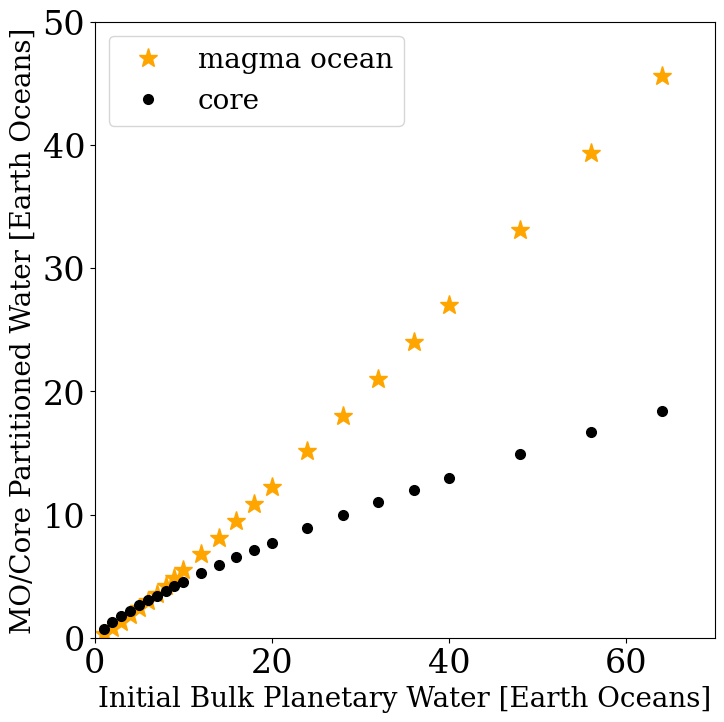

In [36]:
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
fig = plt.figure(figsize=(8,8))

plt.plot(Bulk_H2O_array_plot*(M_E/100.)/1.4e21, M_init_array_plot/1.4e21, color='orange', marker='*', markersize=14, linestyle='', label='magma ocean')
plt.plot(Bulk_H2O_array_plot*(M_E/100.)/1.4e21, M_H2O_core_plot/1.4e21, color='k', marker='.', markersize=14, linestyle='', label='core')
plt.xlim([0., 70.])
plt.xlabel('Initial Bulk Planetary Water [Earth Oceans]', fontsize=20)
plt.ylim([0., 50.])
plt.ylabel('MO/Core Partitioned Water [Earth Oceans]', fontsize=20)
plt.legend(loc='best', fontsize=20)

#plt.savefig('MO_Core_Partitioning_manybulkH2O.pdf', bbox_inches='tight')

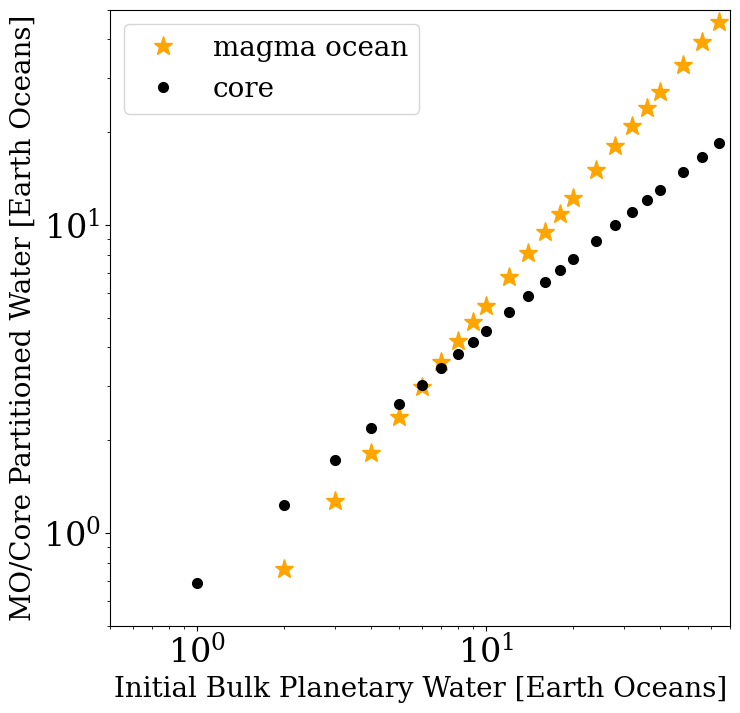

In [37]:
# Same plot as above, but log-log.
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
fig = plt.figure(figsize=(8,8))

plt.loglog(Bulk_H2O_array_plot*(M_E/100.)/1.4e21, M_init_array_plot/1.4e21, color='orange', marker='*', markersize=14, linestyle='', label='magma ocean')
plt.loglog(Bulk_H2O_array_plot*(M_E/100.)/1.4e21, M_H2O_core_plot/1.4e21, color='k', marker='.', markersize=14, linestyle='', label='core')
plt.xlim([0.5, 70.])
plt.xlabel('Initial Bulk Planetary Water [Earth Oceans]', fontsize=20)
plt.ylim([0.5, 50.])
plt.ylabel('MO/Core Partitioned Water [Earth Oceans]', fontsize=20)
plt.legend(loc='best', fontsize=20)

#plt.savefig('MO_Core_Partitioning_manybulkH2O_loglog.pdf', bbox_inches='tight')